TODO
1. open catalogs
2. get relevant information from catalogs
3. get sources that meet AGN crietera (MIR and Xray)
4. get sources that meet data restrictions
5. make full sample plots, highlight sources to be used in paper

In [1]:
# imports
from astropy.io import fits
import matplotlib.pyplot as plt
import plotting as myP
import numpy as np
# import csv 
import match

In [2]:
# path variables 
path_cat = 'D:\\IfA REU\\Catalogs'
path_fig = 'D:\\IfA REU\\IfA-REU-Project\\Figures'
path_csv = 'D:\\IfA REU\\IfA-REU-Project\\Lists'

In [3]:
# set style
myP.SetStyle()

# Get Data

In [4]:
# open COSMOS2020 catalog and get data 
inf20 = fits.open(path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits')
data20 = inf20[1].data
cols20 = inf20[1].columns
inf20.close()
# NOTE: Only run this once! It gets stuck if you try to run this again. If it gets stuck, interrupt and restart the jupyter kernel then run again. 

In [5]:
# open C-COSMOS 2016 catalog file and get data 
inf16 = fits.open(path_cat+'\\chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits')
data16 = inf16[1].data
cols16 = inf16[1].columns
inf16.close()
# NOTE: Only run this once! It gets stuck if you try to run this again. If it gets stuck, interrupt and restart the jupyter kernel then run again. 

In [6]:
# open table with redshifts 
zTable = np.array(myP.ReadFile(path_cat+'\COSMOS_z_matches.csv'))

Cropped:  ['ID', 'z']


# Read relevant columns from catalogs

In [7]:
# get columns from COSMOS2020 for MIR selection 
data20_id       = np.array(data20['ID_COSMOS2015'])     # id
print('.', end='')
data20_ch1      = np.array(data20['SPLASH_CH1_FLUX'])   # 3.5686 um
print('.', end='')
data20_ch2      = np.array(data20['SPLASH_CH2_FLUX'])   # 4.5067 um
print('.', end='')
data20_ch3      = np.array(data20['SPLASH_CH3_FLUX'])   # 5.7788 um
print('.', end='')
data20_ch4      = np.array(data20['SPLASH_CH4_FLUX'])   # 7.9958 um 
print('.', end='')
data20_24um     = np.array(data20['FIR_24_FLUX'])       # Spitzer/MIPS.24mu
print('.', end='')
data20_24umErr  = np.array(data20['FIR_24_FLUXERR'])    # Spitzer/MIPS.24mu error 
print('.', end='')

.......

In [8]:
# get columns from C-COSMOS 2016 for X-ray selection 
L0510_data = np.array(data16['Lx_0510'])            # x-ray luminosity in the 0.5-10 KeV band
print('.', end='')
k0510_data = np.array(data16['abs_corr_0510'])      # absorbtion correction coefficient in the 0.5-10 KeV band
print('.', end='')
data16_id  = np.array(data16['id_k_uv'])            # id 
print('.', end='')

...

In [9]:
# get redshifts 
zTable_id, zTable_z = zTable.T # transpose to get columns 
zTable_id = np.array(zTable_id, dtype=int) # get correct data type
zTable_z  = np.array(zTable_z,  dtype=float)

# Data Cuts
1. Must have id
2. must have redshift
3. must have all four IRAC detections
4. must have 24um detection with fractional error < 50%

In [10]:
def IndexToMask(iList, size) : 
    mask = np.zeros(size, dtype=bool)
    mask[iList] = True 
    return(mask)

In [11]:
# 1. all sources must have id 

# data cut mask 
data20_id_cut1 = (data20_id > 0)    # mask to be used on data20 cols
data16_id_cut1 = (data16_id > 0)    # mask to be used on data16 cols

In [12]:
# 2. all sources mut have a redshift from either catalog 

# mask for valid redshifts 
z_valid = (zTable_z >= 0) & (zTable_z < 99)
zTable_id_v = zTable_id[z_valid]

# match redshift to source 
key_id20, key_z = match.match(data20_id, zTable_id_v)
key_id16, key_z = match.match(data16_id, zTable_id_v)

# data cut mask 
data20_id_cut2 = IndexToMask(key_id20, len(data20_id))   # mask to be used on data20 cols
data16_id_cut2 = IndexToMask(key_id16, len(data16_id))   # mask to be used on data16 cols

In [13]:
# 3. all sources must have IRAC detections in all four channels 

# get nonzero IRAC detection mask 
data20_irac_valid = (data20_ch1 > 0) & (data20_ch2 > 0) & (data20_ch3 > 0) & (data20_ch4 > 0)
data20_id_irac = data20_id[data20_irac_valid]

# match id20s to id16 for irac-detected sources 
key_id20, key_id16 = match.match(data20_id_irac, data16_id)

# data cut mask 
data20_id_cut3 = data20_irac_valid                      # mask to be used on data20 cols
data16_id_cut3 = IndexToMask(key_id16, len(data16_id))  # mask to be used on data16 cols

In [14]:
# 4. all sources must have a 24um detection with a fractional error less than 50%

# get COSMOS2020 sources with small error on 24um 
data20_24um_valid = (data20_24um > 0) & (data20_24umErr > 0 ) & (data20_24umErr/data20_24um < 0.5)
data20_id_24um = data20_id[data20_24um_valid]

# match id20s to id16 for irac-detected sources 
key_id20, key_id16 = match.match(data20_id_24um, data16_id)

# data cut mask 
data20_id_cut4 = data20_24um_valid                      # mask to be used on data20 cols
data16_id_cut4 = IndexToMask(key_id16, len(data16_id))  # mask to be used on data16 cols


C:\Users\polar\AppData\Local\Temp\ipykernel_10036\1842918134.py:4: RuntimeWarning: divide by zero encountered in true_divide
  data20_24um_valid = (data20_24um > 0) & (data20_24umErr > 0 ) & (data20_24umErr/data20_24um < 0.5)


In [38]:
# # print info
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('TOTAL NUMBER OF SOURCES')
# print('COSMOS2020:\t',      len(data20_id))
# print('C-COSMOS 2016:\t',   len(data16_id))
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('CUT 1: have ID')
# print('COSMOS2020:\t',       sum(data20_id_cut1))
# print('C-COSMOS 2016 :\t',   sum(data16_id_cut1))
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('CUT 2: have redshift')
# print('COSMOS2020:\t',       sum(data20_id_cut2))
# print('C-COSMOS 2016:\t',    sum(data16_id_cut2))
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('CUT 3: have four IRAC detections')
# print('COSMOS2020:\t',       sum(data20_id_cut3))
# print('C-COSMOS 2016:\t',    sum(data16_id_cut3))
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('CUT 4: have good 24um detection')
# print('COSMOS2020:\t',       sum(data20_id_cut4))
# print('C-COSMOS 2016:\t',    sum(data16_id_cut4))
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [16]:
# combined data cut lists
data20_id_cut12   = np.logical_and(data20_id_cut1,   data20_id_cut2)
data20_id_cut123  = np.logical_and(data20_id_cut12,  data20_id_cut3)
data20_id_cut1234 = np.logical_and(data20_id_cut123, data20_id_cut4)
# combined data cut lists
data16_id_cut12   = np.logical_and(data16_id_cut1,   data16_id_cut2)
data16_id_cut123  = np.logical_and(data16_id_cut12,  data16_id_cut3)
data16_id_cut1234 = np.logical_and(data16_id_cut123, data16_id_cut4)

In [17]:
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('COSMOS 2020:')
# print('No cut:\t\t',      len(data20_id        ))
# print('Cut 1:\t\t',       sum(data20_id_cut1   ))
# print('Cut 1&2:\t',       sum(data20_id_cut12  ))
# print('Cut 1&2&3:\t',     sum(data20_id_cut123 ))
# print('Cut 1&2&3&4:\t',   sum(data20_id_cut1234))
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print('C-COSMOS 2016:')
# print('No cut:\t\t',      len(data16_id        ))
# print('Cut 1:\t\t',       sum(data16_id_cut1   ))
# print('Cut 1&2:\t',       sum(data16_id_cut12  ))
# print('Cut 1&2&3:\t',     sum(data16_id_cut123 ))
# print('Cut 1&2&3&4:\t',   sum(data16_id_cut1234))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
COSMOS 2020:
No cut:		 1720700
Cut 1:		 865086
Cut 1&2:	 485793
Cut 1&2&3:	 53676
Cut 1&2&3&4:	 35530
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
C-COSMOS 2016:
No cut:		 4016
Cut 1:		 3619
Cut 1&2:	 3455
Cut 1&2&3:	 3182
Cut 1&2&3&4:	 2418


# MIR Selection

In [18]:
def InDonleyWedge(x,y):
    if( x>=0.08 and 
        y>=0.15 and 
        y>=(1.21*x-0.27) and 
        y<=(1.21*x+0.27)
    ) :  
        return(True) 
    else :
        return(False)

In [19]:
def IsMonatomicallRising(
    f36,    # IRAC Ch 1
    f45,    # IRAC Ch 2
    f58,    # IRAC Ch 3
    f80     # IRAC Ch 4
):
    if( f45 > f36 and
        f58 > f45 and
        f80 > f58
    ):
        return(True)
    else :
        return(False)
    

In [20]:
def AGN_DonleyCriterea(
        f36,    # IRAC Ch 1
        f45,    # IRAC Ch 2
        f58,    # IRAC Ch 3
        f80     # IRAC Ch 4
    ) : 

    # get number of sources (assume all IRAC channels are same length)
    numSources = len(f36)
    # initialize mask of False
    AGNmask = np.zeros( numSources, dtype=bool)

    # look at each source 
    for i in range(numSources): 
        # must be nonzero
        if ((f36[i] <= 0) or
            (f45[i] <= 0) or
            (f58[i] <= 0) or
            (f80[i] <= 0)   ):
                continue 
            
        # must fall inside wedge and be monatomically rising
        x = np.log10(f58[i]/f36[i])
        y = np.log10(f80[i]/f45[i])
        if( InDonleyWedge(x,y) and 
            IsMonatomicallRising(f36[i],f45[i],f58[i],f80[i]) 
        ):
            AGNmask[i] = True 

    # return mask where True is an AGN 
    return(AGNmask)


In [21]:
# get mask of sources that meet Donley 2012 criterea for COSMOS2020 col
mirAGNmask = AGN_DonleyCriterea(
                data20_ch1,    # IRAC Ch 1
                data20_ch2,    # IRAC Ch 2
                data20_ch3,    # IRAC Ch 3
                data20_ch4     # IRAC Ch 4
            )

In [22]:
# apply data cuts 
data20_id_agn      = data20_id[mirAGNmask]                      # 0. agn (no restrictions)
data20_id_agn_1    = data20_id[mirAGNmask & data20_id_cut1]     # 1. Must have id
data20_id_agn_12   = data20_id[mirAGNmask & data20_id_cut12]    # 2. must have redshift
data20_id_agn_123  = data20_id[mirAGNmask & data20_id_cut123]   # 3. must have all four IRAC detections
data20_id_agn_1234 = data20_id[mirAGNmask & data20_id_cut1234]  # 4. must have 24um detection with fractional error < 50%

In [23]:
# print number of sources 
print('Number of sources:\t\t\t',                len(data20_id))
print('Number of MIR AGN:\t\t\t',                len(data20_id_agn))
print('Number of MIR AGN (w/id):\t\t',           len(data20_id_agn_1))
print('Number of MIR AGN (w/id,z):\t\t',         len(data20_id_agn_12))
print('Number of MIR AGN (w/id,z,irac):\t',      len(data20_id_agn_123))    # 1156 = previous work
print('Number of MIR AGN (w/id,z,irac,24um):\t', len(data20_id_agn_1234))   # 900  = previous work

Number of sources:			 1720700
Number of MIR AGN:			 1575
Number of MIR AGN (w/id):		 1575
Number of MIR AGN (w/id,z):		 1156
Number of MIR AGN (w/id,z,irac):	 1156
Number of MIR AGN (w/id,z,irac,24um):	 900


In [24]:
# NOTE  in paper, talk about catalog, then cut id and redshift from catalog. then step MIR data, then say which of those are AGN
#       for xray agn, combine irac and 24um

# X-ray Selection

In [25]:
def IntrinsicLuminosity(Lx,k) :
    # correct Luminosity for absorbtion: k_abs = L_abs / L_int --> L_int = L_abs / k_abs 
    luminosity = []
    for lum,abs in zip(Lx,k) : 
        if( lum <= 0) : 
            luminosity.append(-99)
        elif(abs <= 0) : # lum > 0
            luminosity.append(lum)      # assume this source is unobscured 
        else : # lum > 0 and abs > =
            luminosity.append( lum - np.log10(abs))
    return(np.array(luminosity))

In [26]:
def AGN_Xray(L_xray, agnIf=43) : 
    # get number of sources (assume Lx and k are same )
    numSources = len(L_xray)
    # initialize mask of False
    AGNmask = np.zeros( numSources, dtype=bool)
    # a souce is an AGN if luminosity is greater than threshold
    for i,lum in enumerate(L_xray) : 
        if(lum >= agnIf) :
            AGNmask[i] = True 
    # return boolean mask (same size as param) that is True for AGN. 
    return(AGNmask)


In [27]:
# correct luminosity for absorbtion
Lint_data = IntrinsicLuminosity(L0510_data, k0510_data)

In [28]:
# get mask of sources that have intrinsic Xray lum > 10^43 erg/s
xrayAGNmask = AGN_Xray(Lint_data)

In [29]:
# apply data cuts 
data16_id_agn      = data16_id[xrayAGNmask]                      # 0. agn (no restrictions)
data16_id_agn_1    = data16_id[xrayAGNmask & data16_id_cut1   ]  # 1. Must have id
data16_id_agn_12   = data16_id[xrayAGNmask & data16_id_cut12  ]  # 2. must have redshift
data16_id_agn_123  = data16_id[xrayAGNmask & data16_id_cut123 ]  # 3. must have all four IRAC detections
data16_id_agn_1234 = data16_id[xrayAGNmask & data16_id_cut1234]  # 4. must have 24um detection with fractional error < 50%

In [30]:
# print number of sources 
print('Number of sources:\t\t\t',                  len(data16_id))
print('Number of X-ray AGN:\t\t\t',                len(data16_id_agn))
print('Number of X-ray AGN (w/id):\t\t',           len(data16_id_agn_1))
print('Number of X-ray AGN (w/id,z):\t\t',         len(data16_id_agn_12))     # 2232 = previous work
print('Number of X-ray AGN (w/id,z,irac):\t',      len(data16_id_agn_123))    # 2025 = previous work
print('Number of X-ray AGN (w/id,z,irac,24um):\t', len(data16_id_agn_1234))   # 1517 = previous work

Number of sources:			 4016
Number of X-ray AGN:			 2899
Number of X-ray AGN (w/id):		 2672
Number of X-ray AGN (w/id,z):		 2603
Number of X-ray AGN (w/id,z,irac):	 2380
Number of X-ray AGN (w/id,z,irac,24um):	 1775


# Data Scatterplots

In [101]:
def PlotLxVSz_two(
        Lx, z,
        Lx_agn, z_agn
    ) : 
    myP.SetStyle()

    # plot all luminosity points
    plt.scatter(z,      Lx,     marker='.', s=7, c='silver')#,   alpha=0.5)
    plt.scatter(z_agn,  Lx_agn, marker='x', s=10, c=myP.c_xray )#, alpha=0.7)    #,    edgecolors=myP.darken_color(myP.c_xray))

    # plot horizontal dashed line at 10^43 erg/s
    plt.axhline(y=43, color='k', linestyle='dashed')

    # plt.title('Redshift VS. X-ray luminosity from all Chandra 2016 sources')
    plt.xlabel('z')
    plt.ylabel('$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$')
    myP.addtext_n(len(z)+len(z_agn))

    # axis
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_adjustable('box')
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_yticks([40,41,42,43,44,45,46])

    # show plot 
    plt.show()


In [96]:
def PlotLxVSz_one(
        Lx, z
    ) : 
    myP.SetStyle()

    # plot all luminosity points
    plt.scatter(z, Lx, marker='.', c=myP.c_xray, s=2)

    # plot horizontal dashed line at 10^43 erg/s
    plt.axhline(y=43, color='k', linestyle='dashed')

    # plt.title('Redshift VS. X-ray luminosity from all Chandra 2016 sources')
    plt.xlabel('z')
    plt.ylabel('$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$')
    myP.addtext_n(len(z))

    # axis
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_adjustable('box')
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_yticks([43,44,45,46])

    # show plot 
    plt.show()


In [104]:
# GET SOURCES NOT AGN

# match ids to get z
key_id, key_z = match.match(data16_id[data16_id_cut12 & ~(xrayAGNmask & data16_id_cut1234)], zTable_id)
z  = zTable_z[key_z]

# get intrinsic Xray luminosity with redshifts 
Lx = Lint_data[data16_id_cut12 & ~(xrayAGNmask & data16_id_cut1234)][key_id]

# get good data points
mask_nonzeroLx = Lx > 0
Lx_nonzero = Lx[mask_nonzeroLx]
z_Lxnonzero = z[mask_nonzeroLx]
print(len(z_Lxnonzero))


1553


In [103]:
# NOW GET X-RAY AGN w/ data cuts
key_id, key_z = match.match(data16_id[xrayAGNmask & data16_id_cut1234], zTable_id)
z_agn_1234  = zTable_z[key_z]
Lx_agn_1234 = Lint_data[xrayAGNmask & data16_id_cut1234][key_id]
print(len(z_agn_1234))

1775


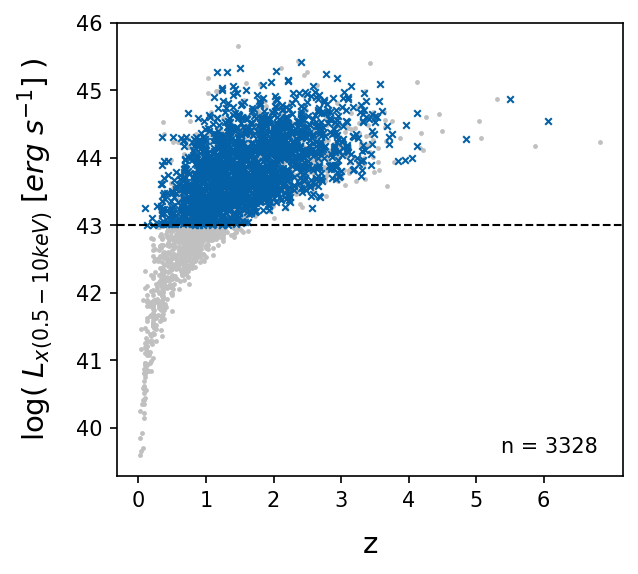

In [102]:
PlotLxVSz_two(
    Lx_nonzero,z_Lxnonzero,
    Lx_agn_1234, z_agn_1234
)

# TODO 
# make gray lighter, or blue more saturated
# make agn different shapes
# remove duplicate agn between gray and blue 

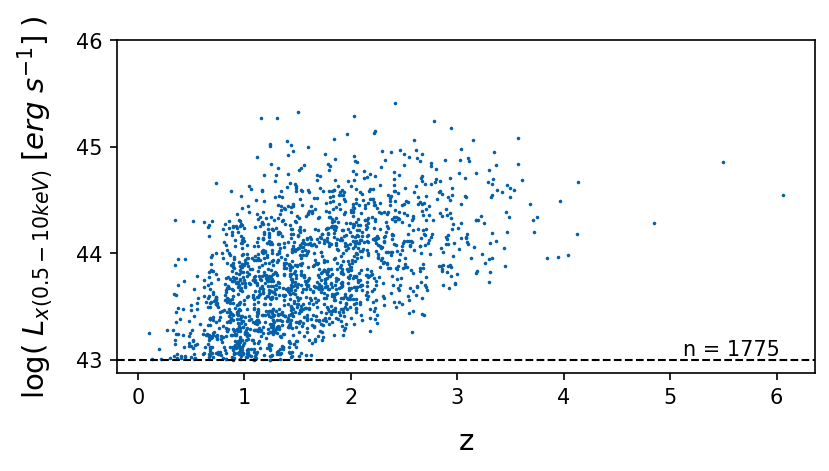

In [35]:
PlotLxVSz_one(
    Lx_agn_1234, z_agn_1234
)

In [36]:
# TODO make MIR AGN color color plots before next meeting

# Export IDs of AGN

In [37]:
# save end data cut only
# others not really needed 